In [2]:
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) 

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score

import os
os.chdir('../')

from utils import BERTEmbExtractor, find_best_ccp_aplpha, metrics, PipePredFeature
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import joblib
import torch

tqdm.pandas()

data = pd.read_csv('/home/admin01/vadim/classifier/Таблица_данные_опроса_+_часть_из_обогащения.csv')
data = data.drop(columns=['ИНН_x', 'ИНН_y', 'Степень уверенности', 'Кол-во вариантов с таким названием компании'])


num_cols = ['Уставный капитал, сумма', 'Среднесписочная численность сотрудников', 'Сумма уплаченных налогов за 2020', 'age']

cat_cols = ['Вид экономической деятельности, ОКВЭД', 
            'Доп вид экономической деятельности_1',
            'Доп вид экономической деятельности_2', 
            'Доп вид экономической деятельности_3',
            'Уставный капитал, тип',
            'Тип по ОКОГУ',
            'Категория из реестра СМП'
            ]

tasks = ['Сфера деятельности по Классификатору ФОИР', 'Карьерная ступень по Классификатору ФОИР']

# extract age
data['Дата рождения'] = pd.to_datetime(data['Дата рождения'], format="%d.%m.%Y")
data['age'] = pd.Timestamp('now').year - data['Дата рождения'].dt.year

# work with target
LE = [LabelEncoder(), LabelEncoder()]
data['label_a'] = LE[0].fit_transform(data[tasks[0]])
data['label_b'] = LE[1].fit_transform(data[tasks[1]])

text_cols  = ['Место работы', 'Наименование текущей должности']
cat_cols += ['Пол', 'Регион', 'Страна проживания', 'Уровень образования', 'Федеральный округ']
data[text_cols] = data[text_cols].fillna('Пропущенное значение')

# split data
df = data.copy()

df_test = df[df['Ручная проверка карьерной ступени'].notna()][cat_cols + text_cols + num_cols ]
y_test = [df[df['Ручная проверка карьерной ступени'].notna()]['label_a'], 
          df[df['Ручная проверка карьерной ступени'].notna()]['label_b']]

df = df[df['Ручная проверка карьерной ступени'].isna()]
df_train, df_val = train_test_split(df, test_size=.20)

y_train = [df_train['label_a'], df_train['label_b']]
df_train = df_train[cat_cols + text_cols + num_cols].copy()

y_val = [df_val['label_a'], df_val['label_b']]
df_val = df_val[cat_cols + text_cols + num_cols].copy()

/home/vadim/work/work_level_classifier/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'matplotlib'

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin


In [12]:
class PipePredFeature(BaseEstimator, TransformerMixin):
    def __init__(self, pipe, col=None):
        super().__init__()
        self.pipe = pipe
        if col:
            self.col = col
        else:
            self.col = 'pipe_pred'
        
    def fit(self, X, y):
        self.pipe.fit(X, y)
        return self
    
    def transform(self, X):
        pred = self.pipe.predict(X)
        return np.hstack([X, pred.reshape(-1, 1)])

In [4]:
from sklearn.pipeline import make_pipeline

In [23]:
# define pipelines and transformer
data_transformer =  ColumnTransformer([
    ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('text_encoder', make_pipeline(BERTEmbExtractor(device=torch.device('cuda'), batch_size=32), PCA(100)), text_cols),
    ('num_features', 'passthrough', num_cols)
    ], remainder='drop', verbose_feature_names_out=True)

data_prepare = Pipeline([
    ('preproc', data_transformer),
    ('imputer', SimpleImputer()),
    ])

pipe_1 = Pipeline([
    ('model', ExtraTreesClassifier(class_weight='balanced_subsample', oob_score=True, bootstrap=True, n_jobs=5))
    ])

pipe_2 = Pipeline([
    ('pred_extract', PipePredFeature(pipe_1)),
    ('model', ExtraTreesClassifier(class_weight='balanced_subsample', oob_score=True, bootstrap=True, n_jobs=5))
])

In [24]:
# prepare Xs
X_train = data_prepare.fit_transform(df_train)
X_val = data_prepare.transform(df_val)
X_test = data_prepare.transform(df_test)

  0%|          | 0/421 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


/home/admin01/vadim/classifier/utils.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/421 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/421 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tens

Сфера деятельности по Классификатору ФОИР

Start compute cost_complexity_pruning_path


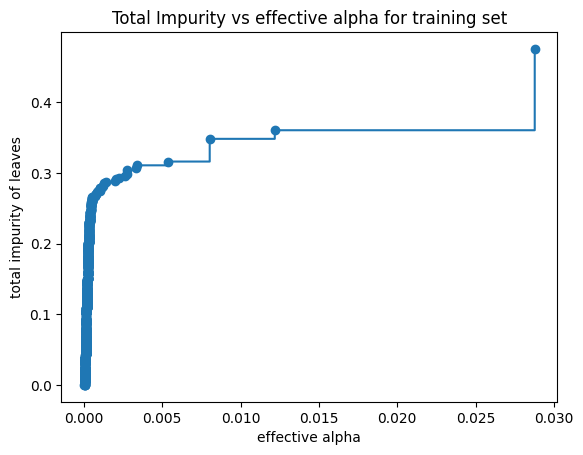

Start searching best ccp alphas


100%|██████████| 45/45 [00:31<00:00,  1.45it/s]


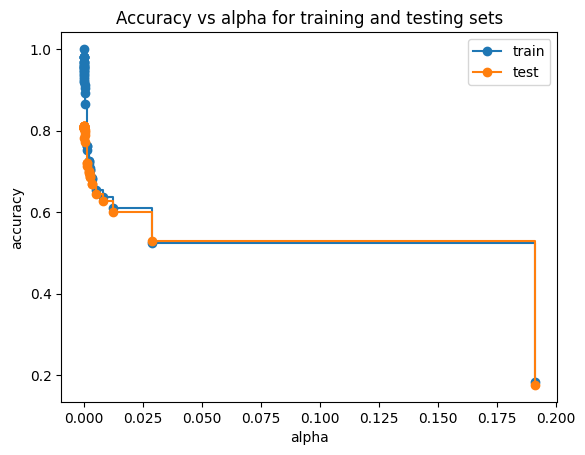

best accuracy val: train 0.9366212898906494 ,0.8119607259744124
Лучший коэф для прунинга 0.00021232922239787836
точность : [0.80773522 0.82298252 0.81256973 0.80245536 0.80691964]

Карьерная ступень по Классификатору ФОИР

Start compute cost_complexity_pruning_path


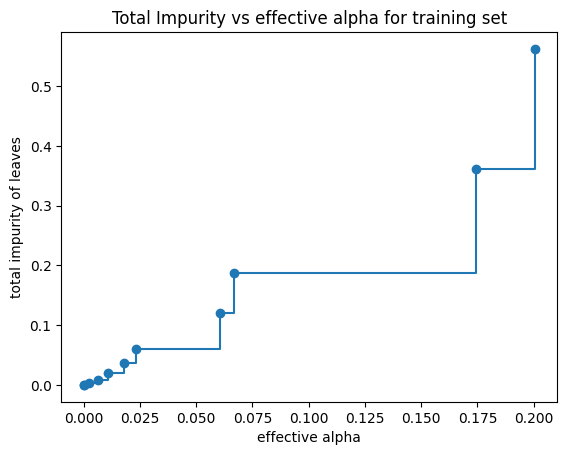

Start searching best ccp alphas


100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


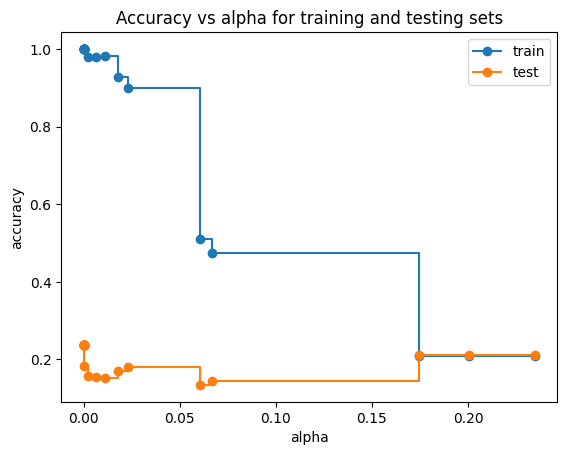

best accuracy val: train 1.0 ,0.2368342755132401
Лучший коэф для прунинга 0.0


/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


точность : [0.38676088 0.39085162 0.39828933 0.375      0.38727679]



In [25]:
# find best hyper params
pipes = []

for i, task in enumerate(tasks):
    print(task)
    print()
    
    
    if i == 0:
        best_ccp = find_best_ccp_aplpha(X_train, y_train[i], X_val, y_val[i])
        
        pipe = Pipeline([
        ('model', ExtraTreesClassifier(class_weight='balanced_subsample', 
                                    oob_score=True, 
                                    bootstrap=True, 
                                    n_jobs=5, 
                                    ccp_alpha=best_ccp))
        ])
        
    else:
        pipe_1 = Pipeline([
        ('model', ExtraTreesClassifier(class_weight='balanced_subsample', 
                                    oob_score=True, 
                                    bootstrap=True, 
                                    n_jobs=5, 
                                    ccp_alpha=best_ccp))
        ])
        
        best_ccp = find_best_ccp_aplpha(np.hstack([X_train, y_train[i].values.reshape(-1, 1)]), y_train[i], 
                                        np.hstack([X_val, y_val[0].values.reshape(-1, 1)]), y_val[i])
        pipe = Pipeline([
            ('pred_extract', PipePredFeature(pipe_1)),
            ('model', ExtraTreesClassifier(class_weight='balanced_subsample', oob_score=True, bootstrap=True, n_jobs=5))
        ])
    
    print('точность :', cross_val_score(pipe, X_train.copy(), y_train[i], n_jobs=1))
    pipe.fit(X_train, y_train[i])
    pipes.append(pipe) 
    print()


In [26]:
%matplotlib inline

              precision    recall  f1-score   support

           0       0.51      0.24      0.33       194
           1       0.91      0.87      0.89      1837
           2       0.00      0.00      0.00        26
           3       0.81      0.48      0.61       126
           4       0.93      0.86      0.89       147
           5       0.60      0.91      0.72       593
           6       0.90      0.83      0.86       233
           7       0.77      0.71      0.74       205

    accuracy                           0.81      3361
   macro avg       0.68      0.61      0.63      3361
weighted avg       0.81      0.81      0.80      3361



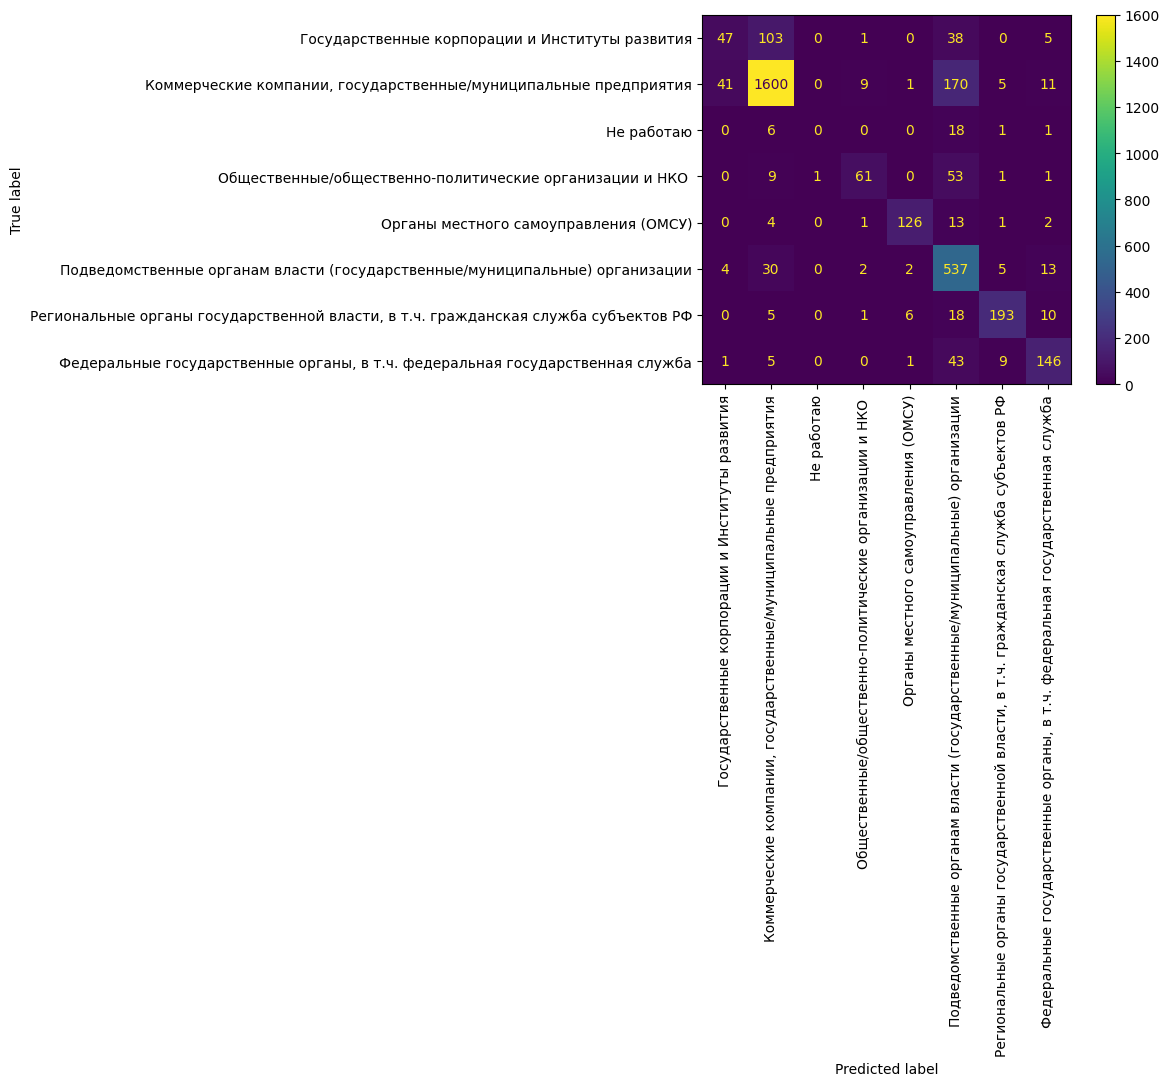

In [27]:
   
# compute metrics
metrics(pipes[0], X_val, y_val[0], LE[0])

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.00      0.00      0.00         0
           3       1.00      0.33      0.50         3
           4       0.83      0.88      0.86        17
           5       0.50      0.78      0.61         9
           6       0.86      0.93      0.89        55
           7       0.89      0.71      0.79        34

    accuracy                           0.80       123
   macro avg       0.73      0.55      0.57       123
weighted avg       0.85      0.80      0.81       123



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


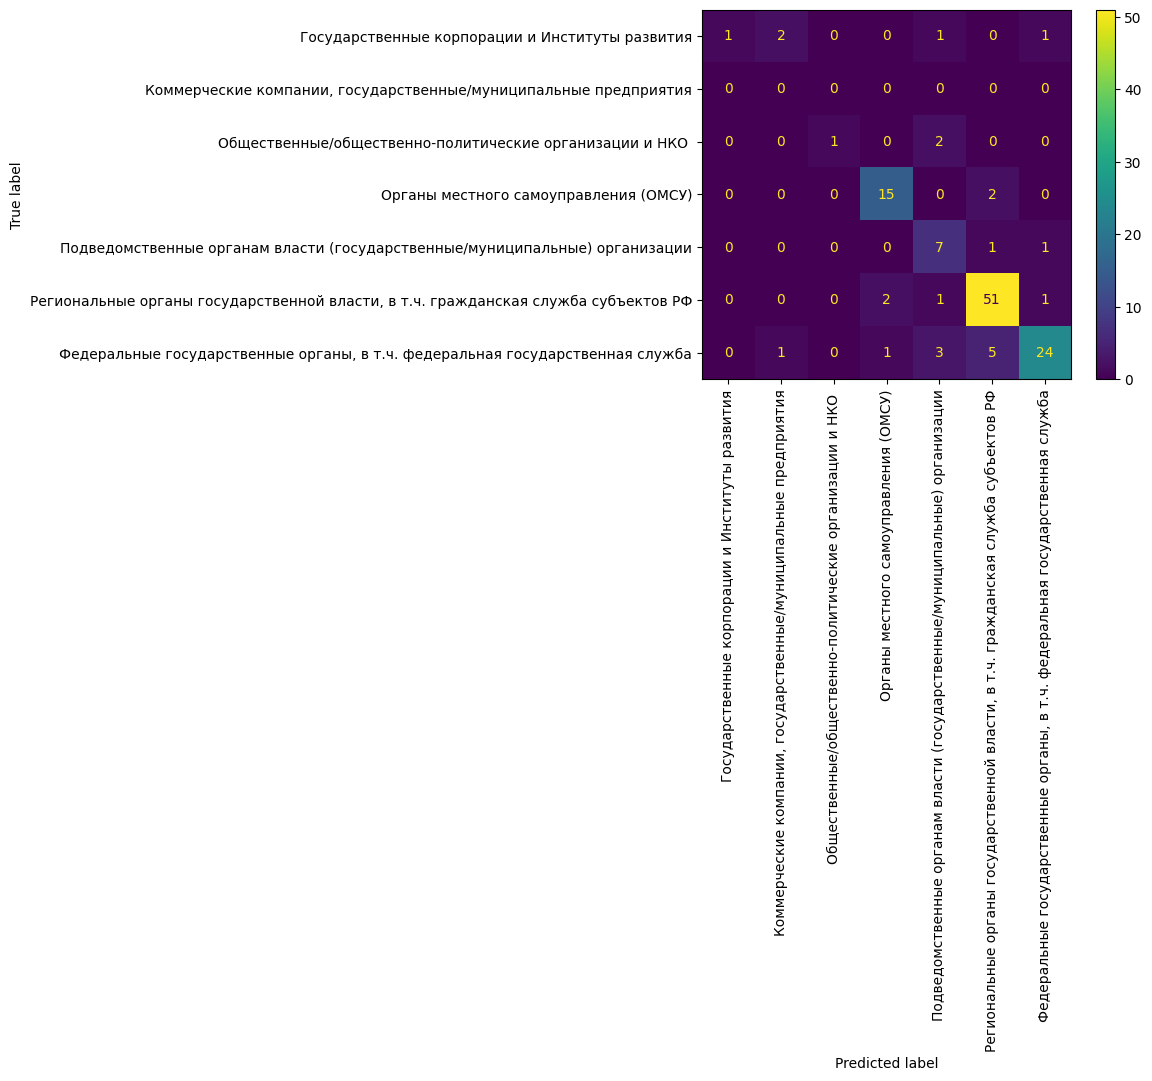

In [28]:
metrics(pipes[0], X_test, y_test[0], LE[0])


/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       0.43      0.56      0.49       826
           1       0.37      0.27      0.31       715
           2       0.39      0.53      0.45       933
           3       0.44      0.19      0.27       201
           4       0.24      0.22      0.23       419
           5       0.14      0.01      0.02        89
           6       0.00      0.00      0.00        80
           7       1.00      0.02      0.05        42
           8       1.00      0.04      0.08        24
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00        26

    accuracy                           0.38      3361
   macro avg       0.33      0.15      0.16      3361
weighted avg       0.37      0.38      0.36      3361



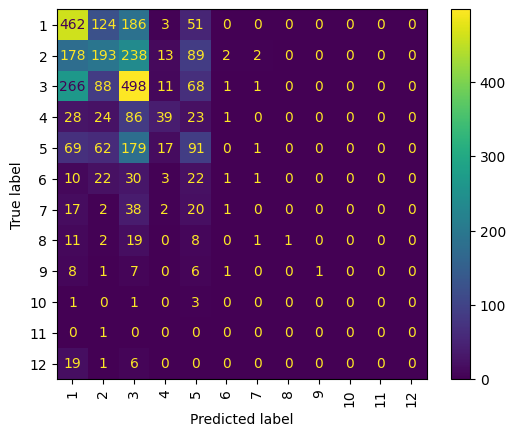

In [29]:
metrics(pipes[1], X_val, y_val[1], LE[1])

              precision    recall  f1-score   support

           0       0.15      0.40      0.22         5
           1       0.35      0.25      0.29        24
           2       0.07      0.25      0.11        12
           3       0.28      0.40      0.33        20
           4       0.20      0.18      0.19        22
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         3

    accuracy                           0.19       123
   macro avg       0.10      0.13      0.10       123
weighted avg       0.16      0.19      0.16       123



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

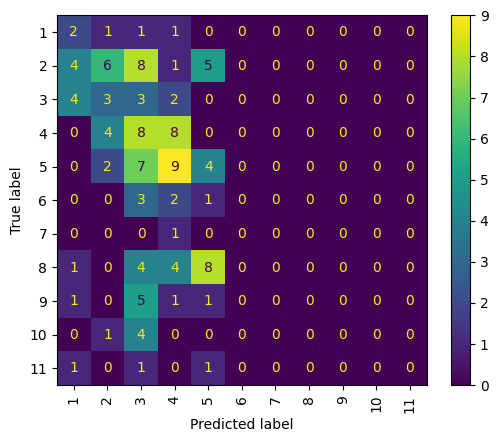

In [30]:
metrics(pipes[1], X_test, y_test[1], LE[1])

Проверим качество только по данным из 2х колонок

In [32]:
df_val[['Пол', 'Регион', 'Страна проживания', 'Уровень образования', 'Федеральный округ']] = None

In [33]:
df_val

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Федеральный округ,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age
2084,Производство строительных металлических констр...,Производство оружия и боеприпасов,Ремонт машин и оборудования,Строительство жилых и нежилых зданий,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,None,None,None,None,None,"ООО ""Специальные сварные металлоконструкции""",Заместитель директора по производству,1.000000e+04,NaN,NaN,35.0
14041,Деятельность в области связи на базе проводных...,Деятельность полиграфическая и предоставление ...,"Производство средств защиты информации, а такж...",Производство контрольно-измерительных и навига...,УСТАВНЫЙ ФОНД,"Федеральная служба по надзору в сфере связи, и...",NaN,None,None,None,None,None,Федеральное государственное унитарное предприя...,"Заместитель руководителя департамента, Департа...",1.567360e+09,NaN,NaN,42.0
3845,Деятельность органов государственной власти су...,NaN,NaN,NaN,NaN,Органы исполнительной власти субъектов Российс...,NaN,None,None,None,None,None,министерство экономики Краснодарского края,начальник управления по финансовому оздоровлен...,NaN,NaN,NaN,47.0
148,"Торговля оптовая автомобильными деталями, узла...",Техническое обслуживание и ремонт автотранспор...,"Торговля розничная автомобильными деталями, уз...",NaN,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,None,None,None,None,None,Пятигорское управление транспортно-экспедицион...,Коммерческий директор,1.000000e+04,4.0,3.120934e+05,44.0
16735,"Деятельность, связанная с использованием вычис...",Разработка компьютерного программного обеспечения,Деятельность консультативная и работы в област...,"Деятельность по обработке данных, предоставлен...",УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",СРЕДНЕЕ ПРЕДПРИЯТИЕ,None,None,None,None,None,ООО ПРОФ-ИТ ЭКСПЕРТ,Функциональный архитектор,1.000000e+04,212.0,1.002893e+08,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15282,Деятельность органов местного самоуправления г...,NaN,NaN,NaN,NaN,Местные администрации (исполнительно-распоряди...,NaN,None,None,None,None,None,Комитет по архитектуре и градостроительству Ад...,Начальник Управления информационного обеспечен...,NaN,NaN,NaN,34.0
6681,Торговля оптовая мясом и мясными продуктами,Деятельность агентов по оптовой торговле сельс...,Деятельность агентов по оптовой торговле прочи...,Деятельность агентов по оптовой торговле пищев...,УСТАВНЫЙ КАПИТАЛ,NaN,NaN,None,None,None,None,None,фудторгпром,директор,1.000000e+04,NaN,NaN,36.0
7845,Образование профессиональное среднее,Прочие виды полиграфической деятельности,Торговля оптовая неспециализированная,Торговля розничная книгами в специализированны...,NaN,Органы исполнительной власти субъектов Российс...,NaN,None,None,None,None,None,"ГАПОУ ""Зеленодольский механический колледж""",заместитель директора по научно-методической р...,NaN,NaN,NaN,48.0
13719,Деятельность прочих общественных организаций и...,Прокат и аренда товаров для отдыха и спортивны...,Деятельность в области спорта,Деятельность спортивных объектов,NaN,Региональные и местные общественные объединения,NaN,None,None,None,None,None,"Красноярская региональная СОО ""Федерация насто...",Секретарь,NaN,NaN,NaN,22.0


In [34]:
X_val = data_prepare.transform(df_val)


  0%|          | 0/106 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/106 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
100%|██████████| 106/106 [00:01<00:00, 80.52it/s]


/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       0.36      0.73      0.48       826
           1       0.36      0.26      0.30       715
           2       0.39      0.38      0.39       933
           3       0.44      0.18      0.25       201
           4       0.32      0.12      0.17       419
           5       0.00      0.00      0.00        89
           6       0.00      0.00      0.00        80
           7       1.00      0.02      0.05        42
           8       1.00      0.04      0.08        24
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00        26

    accuracy                           0.37      3361
   macro avg       0.32      0.14      0.14      3361
weighted avg       0.36      0.37      0.33      3361



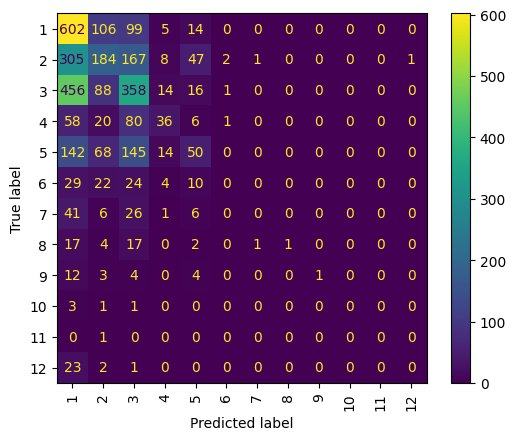

In [36]:
metrics(pipes[1], X_val, y_val[1], LE[1])

              precision    recall  f1-score   support

           0       0.44      0.19      0.26       194
           1       0.91      0.86      0.89      1837
           2       0.00      0.00      0.00        26
           3       0.81      0.44      0.57       126
           4       0.93      0.86      0.89       147
           5       0.59      0.92      0.72       593
           6       0.89      0.82      0.85       233
           7       0.74      0.70      0.72       205

    accuracy                           0.80      3361
   macro avg       0.67      0.60      0.61      3361
weighted avg       0.81      0.80      0.79      3361



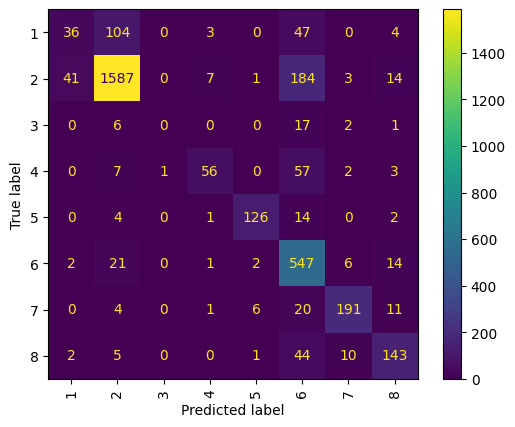

In [37]:
metrics(pipes[0], X_val, y_val[0], LE[1])

In [46]:
df['label_b'].value_counts(normalize=True)[:5].sum()

0.9198405141632944

In [ ]:

# save pipes and transformer
joblib.dump(pipes, 'pipelines.joblib')

# data_prepare.steps[0][1].transformers[1][1].to_device(torch.device('cpu'))
joblib.dump(data_prepare, 'data_prepare.joblib')
joblib.dump(LE, 'label_encoders.joblib')

print('FINISH')